In [59]:
#
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

# -------------------------------------------------------------------------
#  import your own classes  (edit the path / names if different)
# -------------------------------------------------------------------------
from train import QNetwork, Stats, Normaliser     # wherever you defined them


# -------------------------------------------------------------------------
#  Utilities
# -------------------------------------------------------------------------
PITCH_X, PITCH_Y = 104, 68     # grid resolution used in training

def load_checkpoint(path: Path, device: torch.device, layers):
    ckpt = torch.load(path, map_location=device)

    q_net = QNetwork(hidden_layers=layers).to(device)
    q_net.load_state_dict(ckpt["q_net"])
    q_net.eval()

    nd = ckpt["normaliser"]
    stats = Stats(
        nd["state_mean"], nd["state_std"],
        nd["action_mean"], nd["action_std"],
        nd["reward_mean"], nd["reward_std"],
        nd["G_mean"], nd["G_std"],
    )
    return q_net, Normaliser(stats, device)


def ball_start_from_state(state: torch.Tensor) -> tuple[int, int]:
    """Return (x, y) integer coordinates of the ball start-position."""
    dist_img = state[2]                                      # channel-3
    idx = torch.argmin(dist_img)                             # flatten index
    x, y = np.unravel_index(idx.cpu().item(), dist_img.shape)
    return int(x), int(y)                                    # (row, col) → (x, y)


def predict_batch(q_net, norm, states, actions, device):
    s = torch.stack(states).to(device, dtype=torch.float32)
    a = torch.stack(actions).to(device, dtype=torch.float32)
    with torch.no_grad():
        s_n = norm.state(s)
        a_n = norm.action(a)
        return q_net(s_n, a_n).cpu()                         # (B,)


def make_heatmap(vals: np.ndarray, title: str, cmap="viridis"):
    plt.figure(figsize=(5, 7.7))
    plt.imshow(vals, origin="lower", extent=[0, PITCH_Y, 0, PITCH_X],
               aspect="auto", cmap=cmap)
    plt.colorbar(label="Predicted Q-value")
    plt.title(title)
    plt.xlabel("Y (width, m)")
    plt.ylabel("X (length, m)")
    plt.grid(False)


def overlay_players(ax, state):
    tm_coords = torch.nonzero(state[0] != 0)  # teammates
    op_coords = torch.nonzero(state[1] != 0)  # opponents
    if len(tm_coords):
        ax.scatter(tm_coords[:, 1], tm_coords[:, 0],
                   marker="o", s=35, c="dodgerblue", label="Team-mate")
    if len(op_coords):
        ax.scatter(op_coords[:, 1], op_coords[:, 0],
               marker="^", s=35, c="crimson", label="Opponent")
    ax.legend(loc="upper right", fontsize=8)


# -------------------------------------------------------------------------
#  Main evaluation
# -------------------------------------------------------------------------
def evaluate(sample_path: Path, ckpt_path: Path, device, layers,event):
    # ---------------------------------------------------------------------
    # Load state sample  ---------------------------------------------------
    # Each sample is assumed to be the dict you trained with (state, action, etc.)
    # We pull ONLY 'state' here.
    # ---------------------------------------------------------------------
    with Path(sample_path).open("rb") as f:
        sample = pickle.load(f)
    if isinstance(sample, list):          # shard with many samples → use first
        sample = sample[event]
    state = torch.as_tensor(sample["state"], dtype=torch.float32)  # (4,H,W)

    q_net, norm = load_checkpoint(ckpt_path, device, layers)
    bx, by = ball_start_from_state(state)
    print(f"Ball start-pos (x,y) = ({bx}, {by})")

    # ---------------------------------------------------------------------
    # 1. PASS actions  -----------------------------------------------------
    # One action per end-cell on whole pitch (104 × 68)
    # ---------------------------------------------------------------------
    actions_pass, states_pass = [], []
    for x_end in range(PITCH_X):
        for y_end in range(PITCH_Y):
            a = torch.zeros(7)
            a[0] = 1                            # pass
            a[3] = bx; a[4] = by                # start
            a[5] = x_end; a[6] = y_end          # end
            actions_pass.append(a)
            states_pass.append(state)           # same state repeated
    preds_pass = predict_batch(q_net, norm, states_pass, actions_pass, device)
    heat_pass = preds_pass.view(PITCH_X, PITCH_Y).numpy()

    # ---------------------------------------------------------------------
    # 2. SHOT action -------------------------------------------------------
    # ---------------------------------------------------------------------
    shot_action = torch.tensor([0, 0, 1, bx, by, 0, 0], dtype=torch.float32)
    shot_val = predict_batch(q_net, norm, [state], [shot_action], device).item()
    print(f"Predicted Q for SHOT: {shot_val:.3f}")

    # ---------------------------------------------------------------------
    # 3. DRIBBLE actions ---------------------------------------------------
    # 11 × 11 grid in ±5 m square
    # ---------------------------------------------------------------------
    actions_drb, states_drb, dxs, dys = [], [], [], []
    for dx in range(-5, 6):
        for dy in range(-5, 6):
            xe, ye = bx + dx, by + dy
            if 0 <= xe < PITCH_X and 0 <= ye < PITCH_Y:
                a = torch.zeros(7)
                a[1] = 1                        # dribble
                a[3] = bx; a[4] = by            # start
                a[5] = xe; a[6] = ye            # end
                actions_drb.append(a)
                states_drb.append(state)
                dxs.append(dx); dys.append(dy)
    preds_drb = predict_batch(q_net, norm, states_drb, actions_drb, device)
    # map back to 11×11 array centred at (0,0) (missing cells = nan)
    heat_drb = np.full((11, 11), np.nan)
    for val, dx, dy in zip(preds_drb.numpy(), dxs, dys):
        heat_drb[dx + 5, dy + 5] = val

    # ---------------------------------------------------------------------
    #  Visualisation -------------------------------------------------------
    # ---------------------------------------------------------------------
    # PASS heat-map + players
    make_heatmap(heat_pass, "Pass action value-map (a₁ = 1)")
    plt.scatter(by, bx, marker="o", s=20, c="white")  # start-pos
    overlay_players(plt.gca(), state)

    # Enhancements: draw pitch markings
    ax = plt.gca()
    # Halfway line (horizontal line across the center)
    ax.plot([0, PITCH_Y], [PITCH_X/2, PITCH_X/2], color='gray', linestyle='--')
    
    # Center circle (using standard soccer center circle radius ~9.15 m)
    import matplotlib.patches as patches
    center_circle = patches.Circle((PITCH_Y/2, PITCH_X/2), 3.15, fill=False, edgecolor='gray', lw=2)
    ax.add_patch(center_circle)
    
    # Goal depiction: a rectangle at the bottom center (goal width ~7.32 m, depth ~2 m)
    goal_width = 7.32
    goal_depth = 2
    goal_x = (PITCH_Y - goal_width) / 2  # horizontal centering along the width
    ax.add_patch(patches.Rectangle((goal_x, 0), goal_width, goal_depth, fill=False, edgecolor='gray', lw=2))

    ax.add_patch(patches.Rectangle((goal_x, PITCH_X), goal_width, -goal_depth, fill=False, edgecolor='gray', lw=2))

    # DRIBBLE heat-map (local)
    plt.figure(figsize=(5, 5))
    plt.imshow(heat_drb, origin="lower", cmap="plasma",
               extent=[by - 5 - 0.5, by + 5 + 0.5,
                       bx - 5 - 0.5, bx + 5 + 0.5], aspect="equal")
    plt.scatter(by, bx, marker="x", s=60, c="black")  # start-pos
    plt.colorbar(label="Predicted Q-value")
    plt.title("Dribble value-map (±5 m square, a₂ = 1)")
    plt.xlabel("Y"); plt.ylabel("X")
    overlay_players(plt.gca(), state)
    plt.grid(False)

    plt.show()

Ball start-pos (x,y) = (49, 47)
Predicted Q for SHOT: -0.664


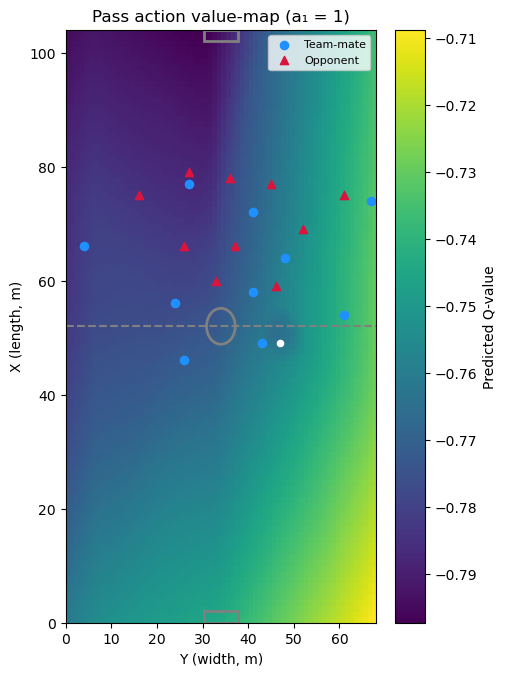

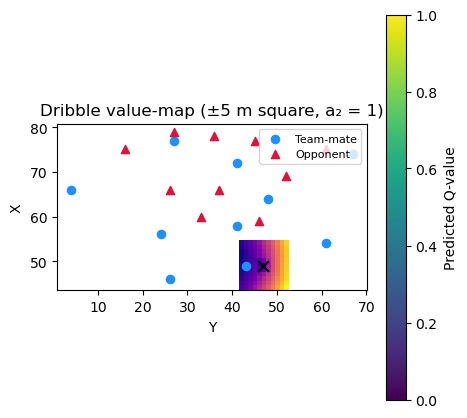

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
shard = 
evaluate('/home/panda/Soccer/data/processed/train/trajectories_032.pkl','/home/panda/Soccer/models/td0/optuna_lr0.00013335932581819005_hd64_nl5.pt', device,layers = 5 * [64],event=10)
# q_net, norm = load_checkpoint('/home/panda/Soccer/models/td0/optuna_lr0.0006706222441748495_hd512_nl3.pt', device)